In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
from tensorflow.keras import models

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [5]:
def print_error_matrix(y_test,y_pred):
    confusion_mtx = tf.math.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx,
                annot=True, fmt='g',
                cmap='coolwarm')
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.show()


def plot_ROC(fpr,tpr,roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0

def evaluate_model_on_folds(model, folds=5, prefix="data/fold_",scaler="MinMaxScaler"):
    metrics = {
        'acc': [],
        'f1': [],
        'precision': [],
        'recall': [],
        'specificity': []
    }

    for i in range(folds):
        train = pd.read_csv(f"{prefix}{i+1}_train.csv")
        test = pd.read_csv(f"{prefix}{i+1}_test.csv")
        
        

        if scaler=="MinMaxScaler":
            test['arrytmia'] = test['arrytmia'].apply(lambda x: 1 if x > 1 else x)
            train['arrytmia'] = train['arrytmia'].apply(lambda x: 1 if x > 1 else x)
            scaler = MinMaxScaler()
            train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
            test = pd.DataFrame(scaler.transform(test), columns=test.columns)

            X_train = train.iloc[:, 1:].values
            y_train = train['arrytmia'].values

            X_test = test.iloc[:, 1:].values
            y_test = test['arrytmia'].values
        else:
            # Przekształcenie kolumny 'arrytmia'
            test['arrytmia'] = test['arrytmia'].apply(lambda x: 1 if x > 1 else x)
            train['arrytmia'] = train['arrytmia'].apply(lambda x: 1 if x > 1 else x)

            test['arrytmia'] = test['arrytmia'].apply(lambda x: -1 if x == 0 else x)
            train['arrytmia'] = train['arrytmia'].apply(lambda x: -1 if x == 0 else x)

            # Przygotowanie danych
            X_train = train.iloc[:, 1:]
            y_train = train['arrytmia'].values

            X_test = test.iloc[:, 1:]
            y_test = test['arrytmia'].values

            # Normalizacja
            scaler = StandardScaler()
            X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
            X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
        

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()

        acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

        metrics['acc'].append(acc)
        metrics['f1'].append(f1)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['specificity'].append(specificity)

    def mean_std_str(metric_list):
        mean = np.mean(metric_list)
        std = np.std(metric_list)
        return f"{mean:.4f} ± {std:.4f}"

    print(f"Accuracy:     {mean_std_str(metrics['acc'])}")
    print(f"F1:           {mean_std_str(metrics['f1'])}")
    print(f"Precision:    {mean_std_str(metrics['precision'])}")
    print(f"Sensitivity:  {mean_std_str(metrics['recall'])}")
    print(f"Specificity:  {mean_std_str(metrics['specificity'])}")

## KNN

In [10]:
knn = KNeighborsClassifier(n_neighbors=50)
evaluate_model_on_folds(knn)


Accuracy:     0.8313 ± 0.0098
F1:           0.8649 ± 0.0066
Precision:    0.8401 ± 0.0136
Sensitivity:  0.8913 ± 0.0025
Specificity:  0.7394 ± 0.0266


## DecisionTree

In [11]:
Dtree = DecisionTreeClassifier(max_depth=30)  
evaluate_model_on_folds(Dtree)

Accuracy:     0.8277 ± 0.0105
F1:           0.8591 ± 0.0080
Precision:    0.8506 ± 0.0111
Sensitivity:  0.8679 ± 0.0065
Specificity:  0.7661 ± 0.0196


## RandomForest

In [12]:
Rforest = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
evaluate_model_on_folds(Rforest)

Accuracy:     0.6853 ± 0.0071
F1:           0.7872 ± 0.0050
Precision:    0.6664 ± 0.0050
Sensitivity:  0.9614 ± 0.0061
Specificity:  0.2618 ± 0.0118


## SVM

## klasyfikator Naive Bayes

In [14]:
NBayes = GaussianNB()
evaluate_model_on_folds(NBayes)

Accuracy:     0.4279 ± 0.0075
F1:           0.2175 ± 0.0361
Precision:    0.6366 ± 0.0389
Sensitivity:  0.1324 ± 0.0256
Specificity:  0.8812 ± 0.0330


## XGBoost

In [15]:
XGBoost = xgb.XGBClassifier()
evaluate_model_on_folds(XGBoost)

Accuracy:     0.8598 ± 0.0113
F1:           0.8855 ± 0.0086
Precision:    0.8764 ± 0.0129
Sensitivity:  0.8947 ± 0.0050
Specificity:  0.8063 ± 0.0224


## LightGBM

In [16]:
LightGBM = lgb.LGBMClassifier(verbose=-1)
evaluate_model_on_folds(LightGBM)

c:\Users\Kuba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Kuba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Kuba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Kuba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy:     0.8411 ± 0.0108
F1:           0.8719 ± 0.0077
Precision:    0.8519 ± 0.0135
Sensitivity:  0.8930 ± 0.0036
Specificity:  0.7614 ± 0.0254


c:\Users\Kuba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## CatBoost

In [17]:
CatB = CatBoostClassifier(verbose=0)
evaluate_model_on_folds(CatB)

Accuracy:     0.8568 ± 0.0107
F1:           0.8832 ± 0.0081
Precision:    0.8726 ± 0.0130
Sensitivity:  0.8943 ± 0.0049
Specificity:  0.7994 ± 0.0229


## Neural Network

In [22]:
def evaluate_given_keras_model(model_builder, scheduler=None, folds=5, prefix="data/fold_", epochs=10, batch_size=32, thresholds=[0.5]):
    from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef

    auc_scores = []
    all_y_true = []
    all_y_pred_prob = []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []

    for i in range(folds):
        train = pd.read_csv(f"{prefix}{i+1}_train.csv")
        test = pd.read_csv(f"{prefix}{i+1}_test.csv")

        train['arrytmia'] = train['arrytmia'].apply(lambda x: 1 if x > 1 else x)
        test['arrytmia'] = test['arrytmia'].apply(lambda x: 1 if x > 1 else x)

        scaler = MinMaxScaler()
        train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
        test = pd.DataFrame(scaler.transform(test), columns=test.columns)

        X_train = train.iloc[:, 1:].values
        y_train = train['arrytmia'].values

        X_test = test.iloc[:, 1:].values
        y_test = test['arrytmia'].values

        model = model_builder(X_train.shape[1])
        callbacks = [scheduler] if scheduler else []

        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                  verbose=0, callbacks=callbacks)

        y_pred_prob = model.predict(X_test).ravel()
        all_y_pred_prob.append(y_pred_prob)
        all_y_true.append(y_test)

        # ROC
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        auc_scores.append(auc(fpr, tpr))

    print("\nWyniki dla różnych wartości threshold:")

    # Zamiana na numpy array
    all_y_true = np.concatenate(all_y_true)
    all_y_pred_prob = np.concatenate(all_y_pred_prob)

    for thresh in thresholds:
        accuracies, f1s, precisions, recalls, specificities, mccs = [], [], [], [], [], []

        start = 0
        for i in range(folds):
            # Oblicz indeks końcowy dla danego folda
            fold_len = len(all_y_true) // folds
            end = start + fold_len if i < folds - 1 else len(all_y_true)

            y_true_fold = all_y_true[start:end]
            y_prob_fold = all_y_pred_prob[start:end]
            y_pred_fold = (y_prob_fold >= thresh).astype(int)

            cm = confusion_matrix(y_true_fold, y_pred_fold)
            tn, fp, fn, tp = cm.ravel()

            acc = accuracy_score(y_true_fold, y_pred_fold)
            f1 = f1_score(y_true_fold, y_pred_fold)
            prec = precision_score(y_true_fold, y_pred_fold, zero_division=0)
            rec = recall_score(y_true_fold, y_pred_fold)
            spec = tn / (tn + fp) if (tn + fp) > 0 else 0
            mcc = matthews_corrcoef(y_true_fold, y_pred_fold)

            accuracies.append(acc)
            f1s.append(f1)
            precisions.append(prec)
            recalls.append(rec)
            specificities.append(spec)
            mccs.append(mcc)

            start = end

        def mean_std_str(metric_list):
            return f"{np.mean(metric_list):.4f} ± {np.std(metric_list):.4f}"

        print(f"\nThreshold = {thresh}")
        print(f"Accuracy:     {mean_std_str(accuracies)}")
        print(f"F1:           {mean_std_str(f1s)}")
        print(f"Precision:    {mean_std_str(precisions)}")
        print(f"Sensitivity:  {mean_std_str(recalls)}")
        print(f"Specificity:  {mean_std_str(specificities)}")
        print(f"MCC:          {mean_std_str(mccs)}")

    mean_auc = np.mean(auc_scores)
    print(f"\nŚredni AUC: {mean_auc:.4f}")

    # Średnia krzywa ROC
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    plt.figure(figsize=(8, 6))
    plt.plot(mean_fpr, mean_tpr, label=f'ROC (AUC = {mean_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Średnia krzywa ROC (5-fold)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step

Wyniki dla różnych wartości threshold:

Threshold = 0.3
Accuracy:     0.7952 ± 0.0212
F1:           0.8500 ± 0.0118
Precision:    0.7656 ± 0.0276
Sensitivity:  0.9567 ± 0.0139
Specificity:  0.5478 ± 0.0722
MCC:          0.5762 ± 0.0388

Threshold = 0.5
Accuracy:     0.8146 ± 0.0094
F1:           0.8517 ± 0.0065
Precision:    0.8265 ± 0.0222
Sensitivity:  0.8797 ± 0.0229
Specificity:  0.7148 ± 0.0467
MCC:          0.6084 ± 0.0220

Threshold = 0.7
Accuracy:     0.7940 ± 0.0128
F1:           0.8180 ± 0.0123
Precision:    0.8790 ± 0.0191
Sensitivity:  0.7656 ± 0.0226
Specificity:  0.8375 ± 0.0294
MCC:          0.5910 ± 0.0264

Średni AUC: 0.8808


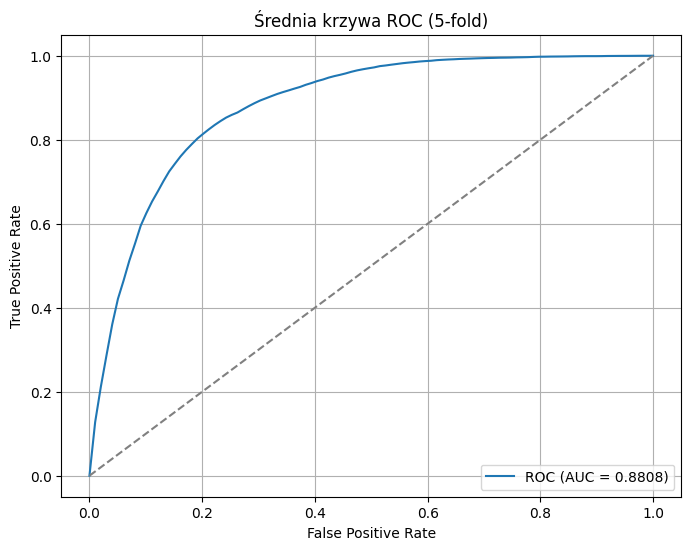

In [23]:
def custom_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

def build_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(1024, activation='relu'), 
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'), 
        layers.Dense(1, activation='sigmoid') 
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

scheduler = LearningRateScheduler(custom_scheduler)
evaluate_given_keras_model(build_model,thresholds=[0.3, 0.5, 0.7], scheduler=scheduler, epochs=10, batch_size=64)


In [7]:
SVM = SVC(kernel='linear')
evaluate_model_on_folds(SVM,scaler="inny")

Accuracy:     0.7144 ± 0.0110
F1:           0.7932 ± 0.0069
Precision:    0.7062 ± 0.0093
Sensitivity:  0.9046 ± 0.0039
Specificity:  0.4225 ± 0.0246


In [6]:
from neo_ls_svm import NeoLSSVM

model = NeoLSSVM()
evaluate_model_on_folds(model,scaler="inny")


Accuracy:     0.7979 ± 0.0116
F1:           0.8394 ± 0.0085
Precision:    0.8091 ± 0.0135
Sensitivity:  0.8721 ± 0.0095
Specificity:  0.6841 ± 0.0270
